### Student Information
Name: 盧子涵

Student ID: 113065542

GitHub ID: luzi2023

Kaggle name: luzi8451

Kaggle private scoreboard snapshot: ![pic0.png](attachment:"img/pic0.png")

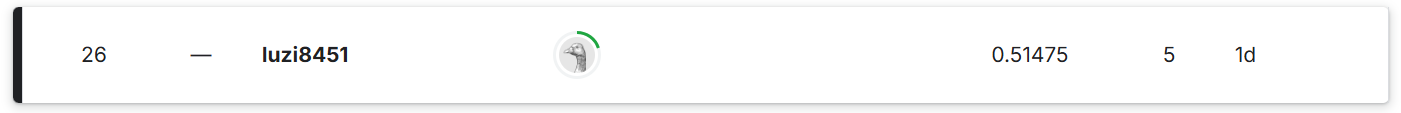

In [1]:
from IPython.display import Image
from IPython.core.display import HTML
PATH = "img/pic0.png"
Image(filename = PATH , width=850, height=600)

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home exercises** in the [DM2024-Lab2-master Repo](https://github.com/didiersalazar/DM2024-Lab2-Master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework) regarding Emotion Recognition on Twitter by this link: https://www.kaggle.com/competitions/dm-2024-isa-5810-lab-2-homework. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (0.6N + 1 - x) / (0.6N) * 10 + 20 points, where N is the total number of participants, and x is your rank. (ie. If there are 100 participants and you rank 3rd your score will be (0.6 * 100 + 1 - 3) / (0.6 * 100) * 10 + 20 = 29.67% out of 30%.)   
    Submit your last submission **BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)**. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developing the model for the competition (You can use code and comment on it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Nov. 26th, 11:59 pm, Tuesday)__. 

### =======================First Part=================================

### Exercise 1

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# train_df
train_all_words = []
for text in train_df['text']:
    train_all_words.extend(word_tokenize(text.lower()))
    
train_word_freq = Counter(train_all_words)
    
train_most_common = train_word_freq.most_common(30)
words, counts = zip(*train_most_common)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.barplot(x=list(counts), y=list(words), ax=axes[0])
axes[0].set_xlabel("Frequency")
axes[0].set_ylabel("Words")
axes[0].set_title("Top 30 Word Frequencies in Train Dataset")

# test_df
test_all_words = []
for text in test_df['text']:
    test_all_words.extend(word_tokenize(text.lower()))

test_word_freq = Counter(test_all_words)

test_most_common = test_word_freq.most_common(30)
words, counts = zip(*test_most_common)

sns.barplot(x=list(counts), y=list(words), ax=axes[1])
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Words")
axes[1].set_title("Top 30 Word Frequencies in Test Dataset")

plt.tight_layout()
plt.show()


### Exercise 2

In [ ]:
# Answer here
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvectorizer = TfidfVectorizer()
X = tfidfvectorizer.fit_transform(train_df['text'])
tfidf_features_name = tfidfvectorizer.get_feature_names_out()
tfidf_features_name[100:110]

### Exercise 3

#### Answer here
The numbers on the diagnal are right-predicted, and the others are wrong. The most wrong cases are 'fear' wrong-predicted as 'anger' then 'anger'
wrong-predicted as 'fear'. We can hypothesis that it might be hard and stuggle for model to distinguish between 'fear' and 'anger'. For having more 
digged in details we can do error analysis to see what exact case will be predicted wrong.

### Exercise 4

In [ ]:
# Answer here
from sklearn.naive_bayes import MultinomialNB

# model
clf = MultinomialNB()
clf.fit(X_train, y_train)

# predict
y_test_pred = clf.predict(X_test)

# evaluate
accuracy = accuracy_score(y_test_pred, y_test)
print(f"testing accuracy: {accuracy:.4f} ")

# plot confusion matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_test_pred)
plot_confusion_matrix(cm, classes=my_tags)

### Exercise 5

##### Answer here
Naive Bayes在測試集上的表現較Decision Tree佳，可能原因有
1. 各特徵間為獨立存在的，使得Naive Bayes在此狀況下更加適用(基於條件機率計算的方式)
2. Decision Tree出現過度記憶訓練集的特徵導致overfitting，在測試集上表現並不如預期

### Exercise 6

In [ ]:
# Answer here
plt.figure(figsize=(4, 3))
plt.plot(training_log['epoch'], training_log['accuracy'], color='blue')
plt.plot(training_log['epoch'], training_log['val_accuracy'], color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train accuracy', 'Val accuracy'], loc='upper right')
plt.title("Accuracy per epoch");

plt.figure(figsize=(4, 3))
plt.plot(training_log['epoch'], training_log['loss'], color='blue')
plt.plot(training_log['epoch'], training_log['val_loss'], color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train loss', 'Val loss'], loc='upper right')
plt.title("Loss per epoch");

According to the "Training Loss per Epoch" plot, the validation loss reaches its minimum at epoch 3. Beyond this point, as the number of epochs increases, the validation loss starts to rise while the training loss continues to decrease. This indicates that the model is overfitting after epoch 3, as it is learning the training set's patterns too well, leading to reduced generalization on the validation set.

### Exercise 7

#### Answer here
可能可以使用
1. 將句子中出現的vector加總或是取平均，其優點是簡單容易計算，缺點是加總或是平均的動作會導致vector之間存在的關聯被消除掉
2. 也可利用加權的方式替較重要的vector提高重要性(類似於TF-IDF)，優點是重要的vector會佔較大的比例，缺點則是需要額外計算加權值

### Exercise 8

In [ ]:
# Answer here
similar_angry = [word[0] for word in w2v_google_model.most_similar('angry', topn=15)]
similar_happy = [word[0] for word in  w2v_google_model.most_similar('happy', topn=15)]
similar_sad = [word[0] for word in w2v_google_model.most_similar('sad', topn=15)]
similar_fear = [word[0] for word in w2v_google_model.most_similar('fear', topn=15)]
all_words = similar_angry + similar_happy +similar_sad + similar_fear

model = w2v_google_model
all_words_train = model[all_words]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=115)

# tsne
tsne = TSNE(n_components=2, metric='cosine', random_state=33)
all_words_tsne = tsne.fit_transform(all_words_train)

color = ['b'] * 15 + ['r'] * 15 + ['y'] * 15 + ['g'] * 15

axes[0].scatter(all_words_tsne[:, 0], all_words_tsne[:, 1], c=color)
for label, x, y in zip(all_words, all_words_tsne[:, 0], all_words_tsne[:, 1]):
    axes[0].annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
axes[0].set_title("TSNE Visualization")

# UMAP
umap_model = umap.UMAP(n_components=2, metric='cosine', random_state=33)
all_words_umap = umap_model.fit_transform(all_words_train)

axes[1].scatter(all_words_umap[:, 0], all_words_umap[:, 1], c=color)
for label, x, y in zip(all_words, all_words_umap[:, 0], all_words_umap[:, 1]):
    axes[1].annotate(label, xy=(x,y), xytext=(0,0),  textcoords='offset points')
axes[1].set_title("UMAP Visualization")

plt.tight_layout();

# 從兩張圖上可以看到 UMAP各類的點較為密集，最明顯的差距在fear中可以看到

### Exercise 9

In [ ]:
# Answer here
# role的目的是定義對話的結構，來知道現在應該是誰在說話，role分成'user', 'system', 'assistant'，加入role可強化對話邏輯
response = ollama.chat(model='llama3.2', messages=[
    {
        "role": "system",
        "content": "You are a helpful assistant knowledgeable about programming."
    },
])

response = ollama.chat(model='llama3.2', messages=[
    {
        "role": "assistant",
        "content": "Here's an example of a Python function:\n```python\ndef greet(name):\n    return f'Hello, {name}!'\n```"
    },
])

print(response['message']['content'])

### Exercise 10

In [ ]:
# Answer here
# response3 = ollama.chat(model='llava-phi3', messages=[
#     {
#         'role': 'user',
#         'content': 'What is this image about?',
#         'images': ['./pics/pandas.jpg'] #Image with pandas
#     },
# ])

# display(Markdown(response3['message']['content']))
# # 他形容得非常準確，包括熊貓的數量、造景的設計及圖片中較次要的光影重點也表達的非常詳細

response3 = ollama.chat(model='llava-phi3', messages=[
    {
        'role': 'user',
        'content': 'What is this image about?',
        'images': ['./pics/HappyNewYear.jpg'] #Image with crowds and fireworks
    },
])

display(Markdown(response3['message']['content']))
# 本來以為模型會對較為密集且資訊量大的圖片存在解讀困難，但從這張圖片的結果來看解讀的狀況並不差，他看到了煙火、人群、也知道人群是在慶祝跨年(非常好奇是怎麼知道的)、甚至節慶氛圍都形容得很準確

### Exercise 11

In [ ]:
# Answer here
import ollama
import bs4
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

llm_model = "llama3.2" #You can change to the one of your preference

# Function to load, split, and retrieve documents
def load_and_retrieve_docs(sources):
    docs = []
    for source in sources:
        loader = WebBaseLoader(web_paths=(source,), bs_kwargs=dict()) 
        docs.extend(loader.load()) #We will load the URL that will serve as our data source
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200) #We will divide the URL in chunks of text for easier comparison in the vector space
    splits = text_splitter.split_documents(docs)
    # print(f"splits: {splits} ") #You can print this to see how the chunks in the url where split
    embeddings = OllamaEmbeddings(model=llm_model) #Generating embeddings with our chosen model
    vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings) #Our vector space for comparison
    return vectorstore.as_retriever()

url=["https://www.ibm.com/topics/large-language-models", "https://en.wikipedia.org/wiki/Large_language_model", "https://www.ibm.com/topics/natural-language-processing"]
# Create the retriever
retriever = load_and_retrieve_docs(url)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs) #Format the retrieved docs in an orderly manner for prompting

# Define the Ollama LLM function
def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = ollama.chat(model='llama3.2', messages=[{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']

# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    return ollama_llm(question, formatted_context)

# Use the RAG chain
result = rag_chain("What are the related solutions of IBM with LLMs?")
display(Markdown(result))

# 當新加入更多的文章參考反而造成回應的準確度降低，RAG的缺點可能包括當檢索到的文檔與問題的相關性過低時，會導致生成回應的準確度降低且過多低質或無關的文檔可能干擾模型，增加錯誤資訊的產生

### Exercise 12

In [ ]:
# Answer here
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(training_log['epoch'], training_log['accuracy'], color='blue')
axes[0].plot(training_log['epoch'], training_log['val_accuracy'], color='red')
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Accuracy")
axes[0].legend(['Train accuracy', 'Val accuracy'], loc='upper right')
axes[0].set_title("Accuracy per epoch");

axes[1].plot(training_log['epoch'], training_log['loss'], color='blue')
axes[1].plot(training_log['epoch'], training_log['val_loss'], color='red')
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Loss")
axes[1].legend(['Train loss', 'Val loss'], loc='upper right')
axes[1].set_title("Loss per epoch");

根據圖表我們可以看到NN在訓練集上的表現都非常好，但在測試集上的表現卻不如訓練集，這是很典型的overfitting的狀況，可能原因是資料集大小太小，導致模型已經過分記憶訓練集中的各個特徵

### Exercise 13

### Answer here
若分為不提供例子(zero-shot))及有提供例子(1-shot and 5-shot)，則為提供例子的表現較提供的略高一點;
推測可能為模型對任務已經十分熟悉，1-shot已足夠讓其了解，故額外的例子對其的效果便沒那麼好了

### =======================Second Part=================================

In [1]:
import pandas as pd
import numpy as np
import json
import emoji
import re
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import transformers
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix

In [2]:
raw_tweet = "tweets_DM.json"
data = []
with open(raw_tweet, "r") as f_in:
    for line in f_in:
        data.append(json.loads(line))

data_identification = pd.read_csv("./data_identification.csv")
submission = pd.read_csv("./sampleSubmission.csv")
# submission.head(3)

In [3]:
# 將emoji轉換成特定token
# emoji_dict = {
#     '😂': '[emoji]',
#     '❤️': '[emoji]',
#     '😍': '[emoji]',
#     '😭': '[emoji]',
#     '❤': '[emoji]',
#     '😊': '[emoji]',
#     '🙏': '[emoji]',
#     '😘': '[emoji]',
#     '💕': '[emoji]',
#     '🔥': '[emoji]',
#     '😩': '[emoji]',
#     '🤔': '[emoji]',
#     '💯': '[emoji]',
#     '💙': '[emoji]',
#     '🙄': '[emoji]',
#     '😁': '[emoji]',
#     '🙌': '[emoji]',
#     '🙏🏾': '[emoji]',
#     '👍': '[emoji]',
#     '🙏🏽': '[emoji]'
# }

emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

def clean_tweet(text, emoji_dict):
    # 將定義的表情符號替換為對應的關鍵詞
    for emj, keyword in emoji_dict.items():
        text = text.replace(emj, keyword)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'<LH>', '', text)
    text = text.strip()
    return text

In [ ]:
# processed_tweets = []
# for entry in data:
#     if '_source' in entry and 'tweet' in entry['_source']:
#         tweet = entry['_source']['tweet']
#         if 'text' in tweet:
#             tweet_text = tweet['text']
#             cleaned_text = clean_tweet(tweet_text, emoji_dict)
#             processed_tweet = {
#                 '_source': {
#                     'tweet': tweet.copy()
#                 }
#             }
#             processed_tweet['_source']['tweet']['text'] = cleaned_text
#             processed_tweets.append(processed_tweet)
#         else:
#             print("記錄中缺少 'text' 鍵")
#     else:
#         print("記錄中缺少 '_source' 或 'tweet' 鍵")

# with open('tweets_DM_filtered_1.json', 'w', encoding='utf-8') as outfile:
#     json.dump(processed_tweets, outfile, ensure_ascii=False, indent=4)

In [3]:
processed_tweets = []
with open('tweets_DM_filtered_emoji.json', 'r', encoding='utf-8') as f_in:
  data = json.load(f_in)
  processed_tweets.append(data)

In [4]:
# 將處理後的資料轉換為 DataFrame
df_processed = pd.DataFrame(processed_tweets)

df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})

In [5]:
df = df.merge(data_identification, on='tweet_id', how='left')

In [6]:
emotions = pd.read_csv("emotion.csv")
emotions['emotion'].value_counts()

emotion
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: count, dtype: int64

In [7]:
# 利用data_identification.csv中的資料拆分出training set及testing set
train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']
train_data = train_data.merge(emotions, on='tweet_id', how='left')
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True)

# 統一submission跟test_data的順序，以方便後續預測結束後填入
test_data.rename(columns={'tweet_id': 'id', 'hashtags': 'hashtags', 'text':'text', 'identification': 'identification'}, inplace=True)

new_submission = submission.copy()

new_submission = new_submission.merge(test_data, on='id')
new_submission.drop(['hashtags', 'identification'], axis='columns', inplace=True)

y_train_data = train_data['emotion']
X_train_data = train_data['text']
X_test_data = new_submission['text']

# 利用oneHot encoding將標籤轉成編碼
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train_data)

/tmp/ipykernel_1816555/2092790352.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.rename(columns={'tweet_id': 'id', 'hashtags': 'hashtags', 'text':'text', 'identification': 'identification'}, inplace=True)


In [ ]:
new_submission.head(3)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train, test_size=0.3, random_state=42, stratify=y_train)

In [10]:
# 想利用不同的模型來達到計算資源及準確度的平衡，使用了TinyBert, distilber, BERT
from transformers import BertTokenizer, BertModel, DistilBertTokenizer

# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokenizer = BertTokenizer.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
max_length = 50
tokenized_train = tokenizer(X_train.tolist(), max_length=max_length, truncation=True, padding=True, return_tensors="pt")
# tokenized_val = tokenizer(X_val.tolist(), max_length=max_length, truncation=True, padding=True, return_tensors="pt")
tokenized_test = tokenizer(X_test_data.tolist(), max_length=max_length, truncation=True, padding=True, return_tensors="pt")

In [ ]:
print(tokenized_train)

In [ ]:
# import torch
# from torch import nn
# from transformers import BertModel, BertTokenizer

# class BertClassifier(nn.Module):
#     def __init__(self):
#         super(BertClassifier, self).__init__()
#         self.bert = BertModel.from_pretrained("bert-base-uncased")
#         # self.bert = BertModel.from_pretrained("huawei-noah/TinyBERT_General_4L_312D")
#         self.classifier = nn.Linear(self.bert.config.hidden_size, 8)

#     def forward(self, input_ids, attention_mask, token_type_ids=None):
#         # BERT 模型輸出
#         outputs = self.bert(input_ids=input_ids, 
#                             attention_mask=attention_mask, 
#                             token_type_ids=token_type_ids
#                             )
#         pooled_output = outputs.pooler_output  # BERT 的 [CLS] token 表示
#         logits = self.classifier(pooled_output)  # 線性層進行分類
#         return logits

In [11]:
import torch
from torch import nn
from transformers import DistilBertModel

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        # 使用 DistilBERT 模型
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.classifier = nn.Linear(self.bert.config.hidden_size, 8)  # 假設有 8 個分類

    def forward(self, input_ids, attention_mask):
        # DistilBERT 輸出 last_hidden_state
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        # 使用 last_hidden_state 的第一個 token 作為句子的表示
        cls_output = outputs.last_hidden_state[:, 0, :]  # 取 [CLS] token 嵌入
        logits = self.classifier(cls_output)  # 線性層進行分類
        return logits


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertClassifier().to(device)

input_ids = torch.tensor(tokenized_train['input_ids'].numpy()).to(device)
attention_mask = torch.tensor(tokenized_train['attention_mask'].numpy()).to(device)
# token_type_ids = torch.tensor(tokenized_train['token_type_ids'].numpy()).to(device)

train_input = {
    'input_ids': input_ids,
    'attention_mask': attention_mask,
    # 'token_type_ids': token_type_ids,
}

y_train = torch.tensor(y_train).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

In [14]:
epochs = 5
batch_size = 16
dataset = torch.utils.data.TensorDataset(
    train_input['input_ids'], train_input['attention_mask'], y_train
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0
    
    for batch in tqdm(dataloader):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        
        logits = model(input_ids, attention_mask)
        
        # 計算損失
        loss = criterion(logits, labels)
        total_loss += loss.item()
        
        # 計算準確率
        _, preds = torch.max(logits, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)
        
        loss.backward()
        optimizer.step()
    
    # 每個 epoch 結束後，計算平均損失和準確率
    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / total_samples
    
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    if epoch == 3:
        torch.save(model.state_dict(), "distilbert_classifier_model_epoch_3.pth")

# 保存模型
torch.save(model.state_dict(), "distilbert_classifier_model_epoch_5.pth")


100%|██████████| 62979/62979 [36:18<00:00, 28.90it/s]


Epoch 1/5
Loss: 1.0975, Accuracy: 0.6032


100%|██████████| 62979/62979 [36:30<00:00, 28.76it/s]


Epoch 2/5
Loss: 0.9498, Accuracy: 0.6572


100%|██████████| 62979/62979 [36:30<00:00, 28.76it/s]


Epoch 3/5
Loss: 0.8409, Accuracy: 0.6970


100%|██████████| 62979/62979 [36:30<00:00, 28.75it/s]


Epoch 4/5
Loss: 0.7326, Accuracy: 0.7361


100%|██████████| 62979/62979 [36:33<00:00, 28.71it/s]


Epoch 5/5
Loss: 0.6289, Accuracy: 0.7739


In [20]:
model.load_state_dict(torch.load("distilbert_classifier_model_epoch_3.pth"))

<All keys matched successfully>

In [16]:
test_dataset = TensorDataset(tokenized_test['input_ids'], tokenized_test['attention_mask'])
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [17]:
# input_ids = torch.tensor(tokenized_val['input_ids'].numpy()).to(device)
# attention_mask = torch.tensor(tokenized_val['attention_mask'].numpy()).to(device)
# token_type_ids = torch.tensor(tokenized_val['token_type_ids'].numpy()).to(device)
test_ids = torch.tensor(tokenized_test['input_ids'].numpy()).to(device)
test_attention_mask = torch.tensor(tokenized_test['attention_mask'].numpy()).to(device)

# val_input = {
#     'input_ids': input_ids,
#     'attention_mask': attention_mask,
#     # 'token_type_ids': token_type_ids,
# }

test_input = {
    'input_ids': test_ids,
    'attention_mask': test_attention_mask
}

# y_val = torch.tensor(y_val).to(device)

In [ ]:
pred = []
model.eval()  # 設置模型為評估模式
with torch.no_grad():  # 推理時不計算梯度
    for batch in tqdm(test_loader):
        input_ids, attention_mask = [x.to(device) for x in batch]
        logits = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(logits, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)
        class_labels = le.inverse_transform(predictions.cpu())
        pred.extend(class_labels)

In [19]:
submission['emotion'] = pred
submission.to_csv("submission_distilbert_epoch_5.csv", index=False)